In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import numpy as np

### Download Shakespeare Dataset

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

--2022-03-01 10:56:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.5.16, 172.217.4.80, 172.217.4.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.5.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: '/tmp/sonnets.txt'

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.05s   

2022-03-01 10:56:20 (1.97 MB/s) - '/tmp/sonnets.txt' saved [93578/93578]



### Define Tokenizer and prepare training data

In [3]:
tokenizer = Tokenizer()

data= open('/tmp/sonnets.txt').read()

corpus = data.lower().split('\n')

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'and': 1, 'the': 2, 'to': 3, 'of': 4, 'my': 5, 'i': 6, 'in': 7, 'that': 8, 'thy': 9, 'thou': 10, 'with': 11, 'for': 12, 'is': 13, 'love': 14, 'not': 15, 'but': 16, 'a': 17, 'me': 18, 'thee': 19, 'so': 20, 'be': 21, 'as': 22, 'all': 23, 'you': 24, 'his': 25, 'which': 26, 'when': 27, 'it': 28, 'this': 29, 'by': 30, 'your': 31, 'doth': 32, 'do': 33, 'from': 34, 'on': 35, 'or': 36, 'no': 37, 'then': 38, 'have': 39, 'what': 40, 'are': 41, 'if': 42, 'more': 43, 'mine': 44, 'their': 45, 'shall': 46, 'sweet': 47, 'time': 48, 'will': 49, 'they': 50, 'beauty': 51, 'nor': 52, 'eyes': 53, 'art': 54, 'her': 55, 'heart': 56, 'yet': 57, 'o': 58, 'than': 59, 'can': 60, 'should': 61, 'thine': 62, 'now': 63, 'where': 64, 'make': 65, 'one': 66, 'hath': 67, 'he': 68, 'fair': 69, 'still': 70, 'how': 71, 'eye': 72, 'him': 73, 'like': 74, 'true': 75, 'see': 76, 'am': 77, 'she': 78, 'those': 79, 'though': 80, 'being': 81, 'some': 82, 'every': 83, 'such': 84, 'own': 85, 'were': 86, 'dost': 87, 'who': 88, 'liv

In [5]:
input_sequences = []

for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

print(len(input_sequences))
print(input_sequences)
#pad sequences
max_sequence_len = max([len(seq) for seq in input_sequences])

print(max_sequence_len, total_words)

input_sequences = np.array(pad_sequences(input_sequences, padding='pre', maxlen=max_sequence_len))

#create predictors and labels
xs, labels = input_sequences[:,:-1], input_sequences[:,-1]
print(labels)
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

15462
[[34, 417], [34, 417, 877], [34, 417, 877, 166], [34, 417, 877, 166, 213], [34, 417, 877, 166, 213, 517], [8, 878], [8, 878, 134], [8, 878, 134, 351], [8, 878, 134, 351, 102], [8, 878, 134, 351, 102, 156], [8, 878, 134, 351, 102, 156, 199], [16, 22], [16, 22, 2], [16, 22, 2, 879], [16, 22, 2, 879, 61], [16, 22, 2, 879, 61, 30], [16, 22, 2, 879, 61, 30, 48], [16, 22, 2, 879, 61, 30, 48, 634], [25, 311], [25, 311, 635], [25, 311, 635, 102], [25, 311, 635, 102, 200], [25, 311, 635, 102, 200, 25], [25, 311, 635, 102, 200, 25, 278], [16, 10], [16, 10, 880], [16, 10, 880, 3], [16, 10, 880, 3, 62], [16, 10, 880, 3, 62, 85], [16, 10, 880, 3, 62, 85, 214], [16, 10, 880, 3, 62, 85, 214, 53], [1372, 9], [1372, 9, 1373], [1372, 9, 1373, 636], [1372, 9, 1373, 636, 11], [1372, 9, 1373, 636, 11, 122], [1372, 9, 1373, 636, 11, 122, 1374], [1372, 9, 1373, 636, 11, 122, 1374, 1375], [201, 17], [201, 17, 1376], [201, 17, 1376, 64], [201, 17, 1376, 64, 518], [201, 17, 1376, 64, 518, 202], [118, 9], 

### **LSTM**

### Define the Model Architecture and start training

In [5]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
# l1 penalize all words, l2 penalize responsible error words like stop words
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           321100    
                                                                 
 lstm (LSTM)                 (None, 10, 128)           117248    
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1605)              207045    
                                                                 
 dense_1 (Dense)             (None, 3211)              5156866   
                                                                 
Total params: 5,933,843
Trainable params: 5,933,843
Non-

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(xs, ys, epochs=150, verbose=1)

Epoch 1/150
484/484 [==============================] - 7s 6ms/step - loss: 6.9681 - acc: 0.0230
Epoch 2/150
484/484 [==============================] - 3s 6ms/step - loss: 6.5294 - acc: 0.0237
Epoch 3/150
484/484 [==============================] - 3s 6ms/step - loss: 6.4436 - acc: 0.0215
Epoch 4/150
484/484 [==============================] - 3s 6ms/step - loss: 6.3565 - acc: 0.0244
Epoch 5/150
484/484 [==============================] - 3s 6ms/step - loss: 6.2440 - acc: 0.0310
Epoch 6/150
484/484 [==============================] - 3s 6ms/step - loss: 6.1448 - acc: 0.0363
Epoch 7/150
484/484 [==============================] - 3s 6ms/step - loss: 6.0575 - acc: 0.0389
Epoch 8/150
484/484 [==============================] - 3s 6ms/step - loss: 5.9782 - acc: 0.0416
Epoch 9/150
484/484 [==============================] - 3s 6ms/step - loss: 5.8958 - acc: 0.0446
Epoch 10/150
484/484 [==============================] - 3s 6ms/step - loss: 5.8177 - acc: 0.0468
Epoch 11/150
484/484 [=================

### Plot the accuracy graph over epochs

In [7]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

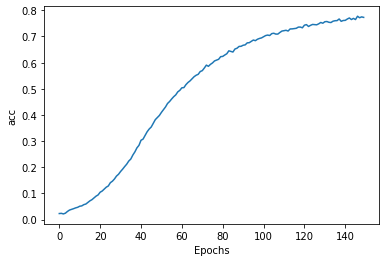

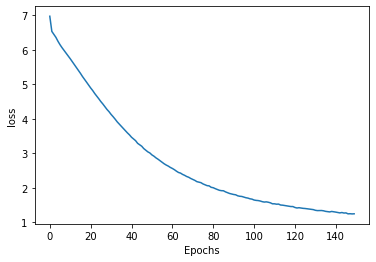

In [8]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

### Save the model

In [9]:
model.save('SimpleRNN_model.h5')

### Generate 100 next words with an initial sample sentence

In [10]:
def predict_next_words(seed_text, next_words):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    classes_x = np.argmax(predicted, axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == classes_x:
        output_word = word
        break
    seed_text += " " + output_word

  print(seed_text)
  return seed_text

In [11]:
seed_text = "from fairest creatures we desire increase"
next_words = 100


generated_text = predict_next_words(seed_text, next_words)

from fairest creatures we desire increase mad bars jaws night back open wide night rage fire right sun one spent spent spent light rage clearer night new spent pride spent stay her night and night by loss night age new night shall place on it still can none bold to change thee as you am so none never common near new near live die in thee ' rolling brought to speed eyes can tell tell to loss so grew by night night lies night more spent open wide night part on time more groan lies live nothing die nothing die dearer green thee still nothing write


In [12]:
seed_text = "why lovest thou that which thou receivest not gladly,"
generated_text = predict_next_words(seed_text, next_words)

why lovest thou that which thou receivest not gladly, glory sit told hate hate pride night greater friend ' me doth cheeks rhyme fire one eyes be kind away things groan of youth go old due of thee of thee blind forth needing forth ground give forth faith on men pride date night of woe o'er spent spent face doth allow survey place day from time still store so chide thee let her night by hide on me decays latch green hate mind give thee seen hate hate none forth forth forth men forth done bow done tell there still live nothing new more mine that that they 'will


In [24]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
# l1 penalize all words, l2 penalize responsible error words like stop words
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 100)           321100    
                                                                 
 lstm_2 (LSTM)               (None, 10, 512)           1255424   
                                                                 
 dropout_3 (Dropout)         (None, 10, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 512)               2099200   
                                                                 
 dense_5 (Dense)             (None, 1605)              823365    
                                                                 
 dense_6 (Dense)             (None, 3211)              5156866   
                                                                 
Total params: 9,655,955
Trainable params: 9,655,955
No

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(xs, ys, epochs=200, verbose=1)

Epoch 1/200
484/484 [==============================] - 6s 8ms/step - loss: 7.1450 - acc: 0.0206
Epoch 2/200
484/484 [==============================] - 4s 8ms/step - loss: 6.5188 - acc: 0.0211
Epoch 3/200
484/484 [==============================] - 4s 8ms/step - loss: 6.4513 - acc: 0.0236
Epoch 4/200
484/484 [==============================] - 4s 8ms/step - loss: 6.3999 - acc: 0.0258
Epoch 5/200
484/484 [==============================] - 4s 8ms/step - loss: 6.3322 - acc: 0.0309
Epoch 6/200
484/484 [==============================] - 4s 8ms/step - loss: 6.2524 - acc: 0.0284
Epoch 7/200
484/484 [==============================] - 4s 8ms/step - loss: 6.1848 - acc: 0.0322
Epoch 8/200
484/484 [==============================] - 4s 8ms/step - loss: 6.1178 - acc: 0.0354
Epoch 9/200
484/484 [==============================] - 4s 8ms/step - loss: 6.0613 - acc: 0.0412
Epoch 10/200
484/484 [==============================] - 4s 8ms/step - loss: 5.9905 - acc: 0.0437
Epoch 11/200
484/484 [=================

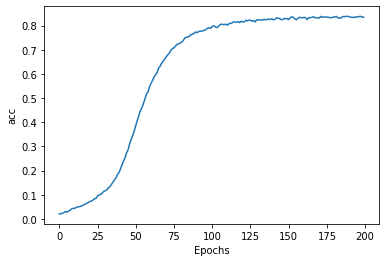

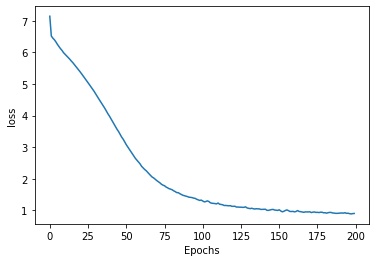

In [26]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

In [27]:
seed_text = "from fairest creatures we desire increase"
next_words = 100

generated_text = predict_next_words(seed_text, next_words)

from fairest creatures we desire increase look prove thee dear deeds gain ' better kept plot well prove thee thee we forgot respect press of time an friend away my heart alone most thee say in thee thy powerful part still be too nearly so thee not 'will' alone nearly me so untutor'd thee 'will' near men old hide me bad 'will' strong pride did strong eyes dwell not ill slain so 'will' fair moon the words ill 'will' ' 'will' 'will' lie did me did hell not white nature boast old spend thee well most hell 'will' fair 'will' not fair my deeds too thee


In [28]:
seed_text = "why lovest thou that which thou receivest not gladly,"
generated_text = predict_next_words(seed_text, next_words)

why lovest thou that which thou receivest not gladly, prove thee twain prove show thee wit you say well did me not write in me when you can leave thee write me write me then love still thy name shall cease away my head state ride dwell swear lie from thee sun too near bearing the prime paws grow'st ' more fair art rare fair thee 'will' lie by the friend dead stay fair fair tune spent light gain lie bars to hell fair night leaves date hide say plea by thee kind now rare twain twain prove thee 'will' shame hits to hell it delight so lie the


### **SimpleRNN**

In [13]:
model1 = Sequential()
model1.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model1.add(SimpleRNN(128, return_sequences=True))  #128 neurons/chains
model1.add(Dropout(0.2))
model1.add(SimpleRNN(128))

model1.add(Dense(total_words, activation='softmax'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 100)           321100    
                                                                 
 simple_rnn (SimpleRNN)      (None, 10, 128)           29312     
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 3211)              414219    
                                                                 
Total params: 797,527
Trainable params: 797,527
Non-trainable params: 0
_________________________________________________________________


In [14]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model1.fit(xs, ys, epochs=150, verbose=1)

Epoch 1/150
484/484 [==============================] - 9s 16ms/step - loss: 6.9386 - acc: 0.0213
Epoch 2/150
484/484 [==============================] - 8s 16ms/step - loss: 6.5021 - acc: 0.0311
Epoch 3/150
484/484 [==============================] - 8s 16ms/step - loss: 6.2205 - acc: 0.0402
Epoch 4/150
484/484 [==============================] - 8s 16ms/step - loss: 5.9063 - acc: 0.0501
Epoch 5/150
484/484 [==============================] - 8s 16ms/step - loss: 5.5735 - acc: 0.0618
Epoch 6/150
484/484 [==============================] - 8s 16ms/step - loss: 5.2401 - acc: 0.0806
Epoch 7/150
484/484 [==============================] - 8s 16ms/step - loss: 4.9122 - acc: 0.1023
Epoch 8/150
484/484 [==============================] - 8s 16ms/step - loss: 4.6067 - acc: 0.1318
Epoch 9/150
484/484 [==============================] - 8s 16ms/step - loss: 4.3070 - acc: 0.1633
Epoch 10/150
484/484 [==============================] - 8s 16ms/step - loss: 4.0233 - acc: 0.2111
Epoch 11/150
484/484 [=======

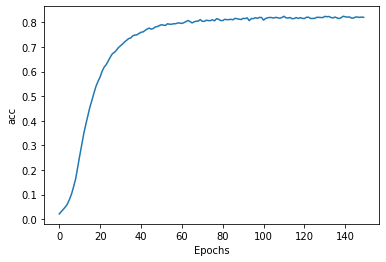

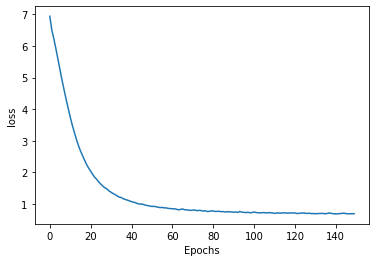

In [15]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

In [16]:
def predict_next_words1(seed_text, next_words):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model1.predict(token_list, verbose=0)
    classes_x = np.argmax(predicted, axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == classes_x:
        output_word = word
        break
    seed_text += " " + output_word

  print(seed_text)
  return seed_text

In [17]:
seed_text = "from fairest creatures we desire increase"
next_words = 100


generated_text = predict_next_words1(seed_text, next_words)

from fairest creatures we desire increase lie are riper in my breast doth lie from other words hate still behold store old give them then in every thing she had men make their lease check face of view of quite living no dost every shade shines so true heaven thy spirit the youth in every thing thou dost common place a tomb of good respect evil luck light shore pride oaths nothing all my sum of good respect lies we bear prove another very tomb his dignity complexion dimm'd survey chary of thine dear love then better in my mistress' face though words come sensual forgot


In [ ]:
seed_text = "why lovest thou that which thou receivest not gladly,"
generated_text = predict_next_words1(seed_text, next_words)

why lovest thou that which thou receivest not gladly, be gone pride nor see thou wouldst to groan alone think me for beauty's part to day to morrow kind disdain his dye prove taken ' esteem'd to show thee told the sweetest birds are o'er the ocean away he last so destroys it wit use my body are all and it please them thou art old world could see the earth of bath desired change decrees of kings pride not in my grief lies express'd remedy brow hits quality our youthful sap at height decrease disdain way place me becoming of things ill aside never shadow of your mind


In [ ]:
model1 = Sequential()
model1.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model1.add(SimpleRNN(128, return_sequences=True))  #128 neurons/chains
model1.add(Dropout(0.2))
model1.add(SimpleRNN(128))

# l1 penalize all words, l2 penalize responsible error words like stop words
model1.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dense(total_words, activation='softmax'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 100)           321100    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10, 128)           29312     
                                                                 
 dropout_2 (Dropout)         (None, 10, 128)           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1605)              207045    
                                                                 
 dense_4 (Dense)             (None, 3211)              5156866   
                                                                 
Total params: 5,747,219
Trainable params: 5,747,219
No

In [20]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model1.fit(xs, ys, epochs=150, verbose=1)

Epoch 1/150
484/484 [==============================] - 9s 16ms/step - loss: 7.0331 - acc: 0.0225
Epoch 2/150
484/484 [==============================] - 8s 16ms/step - loss: 6.5486 - acc: 0.0249
Epoch 3/150
484/484 [==============================] - 8s 16ms/step - loss: 6.3855 - acc: 0.0352
Epoch 4/150
484/484 [==============================] - 8s 16ms/step - loss: 6.2147 - acc: 0.0378
Epoch 5/150
484/484 [==============================] - 8s 16ms/step - loss: 6.0753 - acc: 0.0407
Epoch 6/150
484/484 [==============================] - 8s 16ms/step - loss: 5.9608 - acc: 0.0466
Epoch 7/150
484/484 [==============================] - 8s 16ms/step - loss: 5.8480 - acc: 0.0481
Epoch 8/150
484/484 [==============================] - 8s 16ms/step - loss: 5.7537 - acc: 0.0537
Epoch 9/150
484/484 [==============================] - 8s 16ms/step - loss: 5.6491 - acc: 0.0583
Epoch 10/150
484/484 [==============================] - 8s 16ms/step - loss: 5.5549 - acc: 0.0613
Epoch 11/150
484/484 [=======

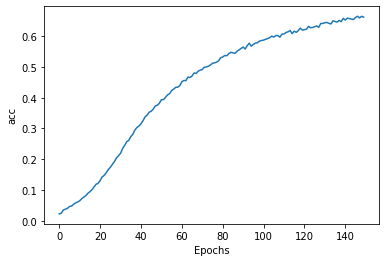

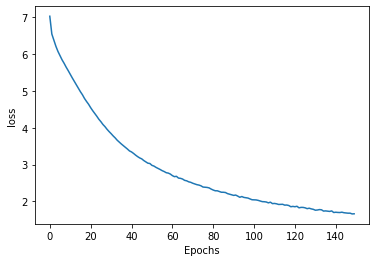

In [21]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

In [22]:
seed_text = "from fairest creatures we desire increase"
next_words = 100


generated_text = predict_next_words1(seed_text, next_words)

from fairest creatures we desire increase took or care in time which live acquainted grow where her poor world's reeks at to rehearse still taken hate where it may leave my body that thy brains plot care my rest privilege far of time did end dead jaws his state too hammer'd steel part all my love thy state where thou alchemy declines in his motion doth make approve it dumb age of in this invited esteem'd tell his might more twain of woe doth green another place if thou dost love against myself and bred no sum of good rage would dove wanting dull the truth


In [23]:
seed_text = "why lovest thou that which thou receivest not gladly,"
generated_text = predict_next_words1(seed_text, next_words)

why lovest thou that which thou receivest not gladly, me seconds but lie but again on him depart clears you leave what half be cruel how pass this line an end show appear shine prove love my pain be prove these dear spirit in me my passion sweets favour of his throned queen got of greatest that flesh mounted to the beams assemble of days doth fuel can express'd unused in an lusty doom and day doth stand confined other days did place with hide my thoughts in every thing an frame another mind shall still from thee may be deceived up in love's deaths decay love redeem three
